### Athens University of Economics and Business
### Department of Management Science & Technology
### Msc in Business Analytics

### Course : Machine Learning & Content Analytics
* ### Instructors : H.Papageorgiou, G.Perakis
* ### Students : Xheni Cobanaj (f2822117), Nikolaos Mantzakos (f2822107), Dimitris Papageorgiou (f2822109)

* Import of necessary libraries :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib inline
import re
import itertools
import string
import collections
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,Embedding,Flatten,Dropout,Activation
from tensorflow.python.keras import metrics,regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers import LSTM, Input, Concatenate, Bidirectional, concatenate
from tqdm import tqdm
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/MyDrive/mbti_1.csv"

/content/drive/MyDrive/mbti_1.csv


In [5]:
df = pd.read_csv("/content/drive/MyDrive/mbti_1.csv",header=0)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


# Data Cleaning & Preprocessing

In [6]:
def text_cleaning(text):
  
  # make all characters lowercase
  text = text.lower()

  # removing the posts delimiter  
  text = text.replace("|"," ") 

  # removing the urls
  text = re.sub(r'https?:\/\/.*?[\s+]', '',text)

  # removing Punctation
  text = re.sub('[%s]*' % string.punctuation, '',text)

  # removing numbers
  text = re.sub('[0-9]+','', text)
   
  # removing non-words 
  text = re.sub(r'[^a-zA-Z\s]','',text)

  # removing the personallity type codes 
  pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
  pers_types = [p.lower() for p in pers_types]
  
  for t in pers_types:
      text = text.replace(t,"")


  # removing big spaces
  text = re.sub(' +', ' ', text) 

  

  return(text)  

In [7]:
# function for producing the four binary target variables
def categories(df):
  df['Extraversion'] = ''
  df['Sensing'] = ''
  df['Thinking'] = ''
  df['Judging'] = ''

  for i in df.index:    
    if "E" in df['type'][i]:
      df['Extraversion'][i] = 1
    else:
      df['Extraversion'][i] = 0

    if "S" in df['type'][i]:
      df['Sensing'][i] = 1
    else:
      df['Sensing'][i] = 0
    
    if "T" in df['type'][i]:
      df['Thinking'][i] = 1
    else:
      df['Thinking'][i] = 0
    
    if "J" in df['type'][i]:
      df['Judging'][i] = 1
    else:
      df['Judging'][i] = 0
  return(df)

In [8]:
data = df.copy()

In [9]:
data['tokens'] = data['posts'].apply(lambda s : s.split('|||'))
data = data.explode('tokens').reset_index()
data.head()

,index,type,posts,tokens
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,enfp and intj moments https://www.youtube.com...
3,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,What has been the most life-changing experienc...
4,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


In [10]:
data['tokens'] = data.tokens.str.split()

In [11]:
data['selected_tokens'] = data.tokens.apply(lambda arr : ' '.join(arr[:6]))

In [12]:
data_tr= data.groupby('index').agg({'selected_tokens': lambda arr : ' '.join(arr)})
data_tr = pd.concat([data_tr,df['type']], axis=1)
data_tr

,selected_tokens,type
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,INFJ
1,'I'm finding the lack of me Sex can be boring ...,ENTP
2,'Good one _____ https://www.youtube.com/watch?...,INTP
3,"'Dear INTP, I enjoyed our conversation Dear EN...",INTJ
4,'You're fired. That's another silly misconcept...,ENTJ
...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 I...,ISFP
8671,'So...if this thread already exists someplace ...,ENFP
8672,'So many questions when i do I worked in a bre...,INTP
8673,'I am very conflicted right now If I had to gu...,INFP


In [13]:
categories(data_tr)

,selected_tokens,type,Extraversion,Sensing,Thinking,Judging
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...,INFJ,0,0,0,1
1,'I'm finding the lack of me Sex can be boring ...,ENTP,1,0,1,0
2,'Good one _____ https://www.youtube.com/watch?...,INTP,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation Dear EN...",INTJ,0,0,1,1
4,'You're fired. That's another silly misconcept...,ENTJ,1,0,1,1
...,...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 I...,ISFP,0,1,0,0
8671,'So...if this thread already exists someplace ...,ENFP,1,0,0,0
8672,'So many questions when i do I worked in a bre...,INTP,0,0,1,0
8673,'I am very conflicted right now If I had to gu...,INFP,0,0,0,0


In [14]:
data_tr['selected_tokens'] = data_tr.selected_tokens.apply(text_cleaning)

In [15]:
data_tr.head()

,selected_tokens,type,Extraversion,Sensing,Thinking,Judging
0,and moments sportscenter what has been the mo...,INFJ,0,0,0,1
1,im finding the lack of me sex can be boring if...,ENTP,1,0,1,0
2,good one of course to which i say does being a...,INTP,0,0,1,0
3,dear i enjoyed our conversation dear sub long ...,INTJ,0,0,1,1
4,youre fired thats another silly misconception ...,ENTJ,1,0,1,1


In [16]:
data_tr['posts_length'] = data_tr['selected_tokens'].apply(lambda x : len(x.split(' ')))

<Figure size 1152x576 with 0 Axes>

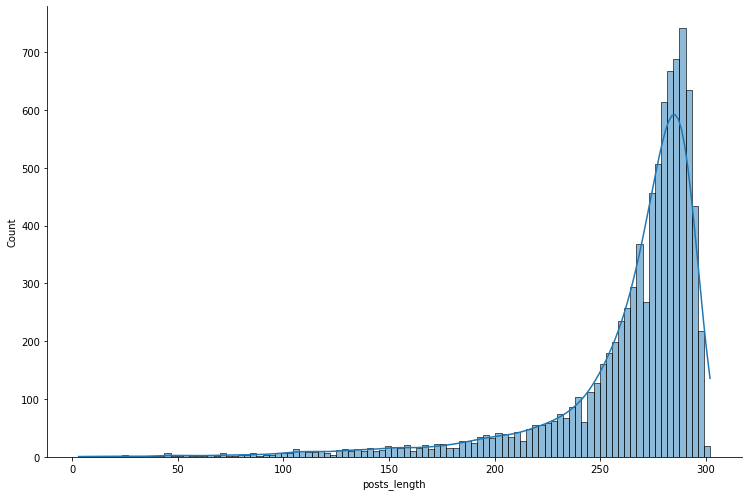

In [17]:
plt.figure(figsize=(16,8))
sns.displot(data_tr.posts_length,kde=True,height=7,aspect=1.5)
plt.show()

In [18]:
print("Max :",data_tr.posts_length.max())
print("Mean :",data_tr.posts_length.mean())
print("Median :",data_tr.posts_length.median())
print("Mode :",data_tr.posts_length.mode())

Max : 302
Mean : 263.41821325648414
Median : 277.0
Mode : 0    289
dtype: int64


# Data Split

In [19]:
X = data_tr['selected_tokens']
y = data_tr[['Extraversion','Sensing','Thinking','Judging']]
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.1,
                                                            random_state=20,
                                                            stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10, 
                                                  random_state=20,
                                                  stratify=y_train_val)

# Tokenization and Padding

In [20]:
uniqueWords = list(set(" ".join(X_train).lower().split(" ")))
count = len(uniqueWords)
count

56550

In [21]:
max_words = 30000

tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')
tokenizer

In [22]:
tokenizer.fit_on_texts(X_train)

In [23]:
X_train_enc  = tokenizer.texts_to_sequences(X_train)
X_val_enc  = tokenizer.texts_to_sequences(X_val)
X_test_enc  = tokenizer.texts_to_sequences(X_test)

In [24]:
maxlen = 280

X_train_enc = pad_sequences(X_train_enc,padding='pre',maxlen=maxlen)
X_val_enc = pad_sequences(X_val_enc,padding='pre', maxlen=maxlen)
X_test_enc = pad_sequences(X_test_enc, padding='pre', maxlen=maxlen)

print('New data shape: {}'.format(X_train_enc.shape))
print('New data shape: {}'.format(X_val_enc.shape))
print('New data shape: {}'.format(X_test_enc.shape))

New data shape: (7026, 280)
New data shape: (781, 280)
New data shape: (868, 280)


# Target Encoding

In [25]:
y_train_enc = np.array(y_train).astype('float32')
y_train_enc

array([[0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 1., 0.]], dtype=float32)

In [26]:
y_val_enc = np.array(y_val).astype('float32')
y_test_enc = np.array(y_test).astype('float32')

# Glove pretrained embeddings

In [27]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-08-25 21:04:40--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-08-25 21:04:40--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-08-25 21:04:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [28]:
def load_glove_embeddings(dim: int = 100) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'glove.6B.{}d.txt'.format(dim)

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [29]:
embedding_dim = 300

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading word vectors


Loading Embeddings: 400000word [00:25, 15458.83word/s]

Found 400000 word vectors.


In [30]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 100) -> np.ndarray:
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the glove embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [31]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=tokenizer,
                                            emb_dim=embedding_dim)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 23092 pre-trained embeddings out of 30000


# GRU MODEL

## Model Callbacks

In [32]:
monitor = 'val_loss'

model_gru = 'model_gru.h5'

callbacks_gru = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_gru,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

## Model Architecture

In [33]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [35]:
#network hyperparameters
nb_classes = len(y_train_enc[0])

print('Number of Classes (Personality Components): {}'.format(nb_classes))


#Setting model hyperparameters
batch_size=64 # batch=64 =>  in each iteration, we consider 64 training examples at once
num_epochs=50

Number of Classes (Personality Components): 4


In [42]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim,input_length=maxlen, weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 280, 300)          9000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              330240    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 300)               77100     
                                                                 
 dense_3 (Dense)             (None, 4)                 1204      
                                                                 
Total params: 9,408,544
Trainable params: 408,544
Non-trainable params: 9,000,000
_________________________________________________________________


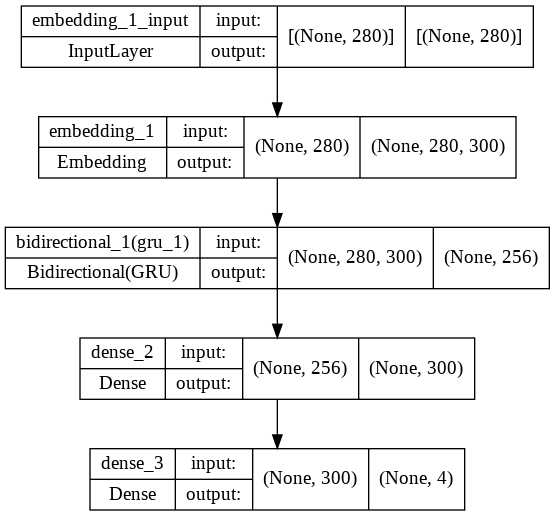

In [62]:
plot_model(model_gru,show_shapes=True)

In [43]:
model_gru.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['binary_accuracy','accuracy'])

In [44]:
history_gru = model_gru.fit(
    x=X_train_enc,           # features (as dense inputs)
    y=y_train_enc,           # labels
    batch_size=batch_size,   # define batch size
    epochs=num_epochs,         # number of epochs
    verbose=2,               # the most extended verbosity level
    validation_data=(       
    X_val_enc,               # the validation split that we did before
    y_val_enc),
    callbacks=callbacks_gru
)

Epoch 1/50

Epoch 00001: val_loss did not improve from 0.55548
110/110 - 7s - loss: 0.5918 - binary_accuracy: 0.6816 - accuracy: 0.2653 - val_loss: 0.5785 - val_binary_accuracy: 0.6924 - val_accuracy: 0.2804 - lr: 1.0000e-04 - 7s/epoch - 62ms/step
Epoch 2/50

Epoch 00002: val_loss did not improve from 0.55548
110/110 - 3s - loss: 0.5746 - binary_accuracy: 0.6967 - accuracy: 0.2727 - val_loss: 0.5758 - val_binary_accuracy: 0.6962 - val_accuracy: 0.2727 - lr: 1.0000e-04 - 3s/epoch - 28ms/step
Epoch 3/50

Epoch 00003: val_loss did not improve from 0.55548
110/110 - 3s - loss: 0.5717 - binary_accuracy: 0.7000 - accuracy: 0.2738 - val_loss: 0.5753 - val_binary_accuracy: 0.6988 - val_accuracy: 0.2638 - lr: 1.0000e-04 - 3s/epoch - 28ms/step
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.55548
110/110 - 3s - loss: 0.5689 - binary_accuracy: 0.7035 - accuracy: 0.2775 - val_loss: 0.5738 - val_binary_accuracy: 0.7007 - val_accuracy: 0.2650 - lr: 1.0000e-04 - 3s/epoch - 28ms/step
Epoch 5/

## Model Evaluation

In [60]:
score_gru = model_gru.evaluate(
    X_val_enc,                 
    y_val_enc,                 
    batch_size=batch_size,   
    verbose=1                
)

7/7 [==============================] - 0s 30ms/step - loss: 0.5476 - binary_accuracy: 0.7362 - accuracy: 0.3521


In [61]:
print('\nValidation binary_crossentropy: {}'.format(score_gru[0]))
print('\nValidation binary accuracy: {:.3f} %'.format(score_gru[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_gru[2]*100))


Validation binary_crossentropy: 0.5475870370864868

Validation binary accuracy: 73.624 %

Validation accuracy: 35.211 %


In [59]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

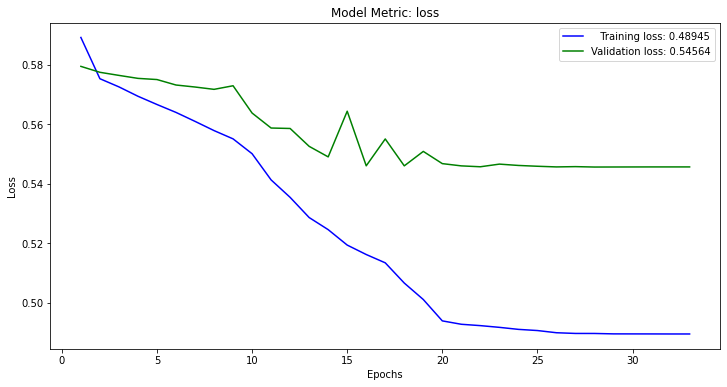

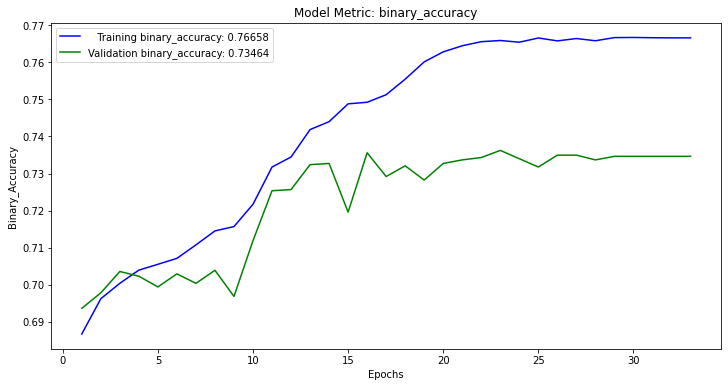

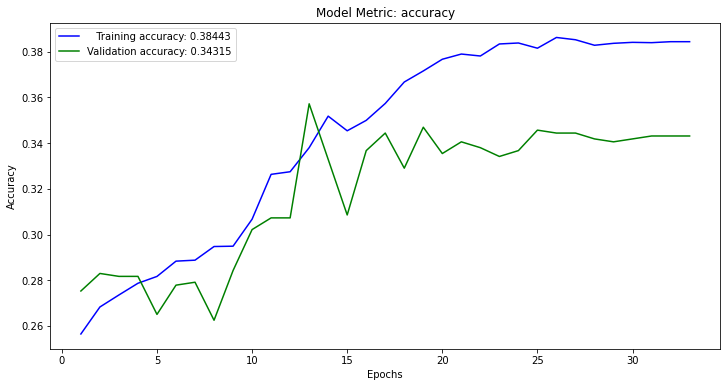

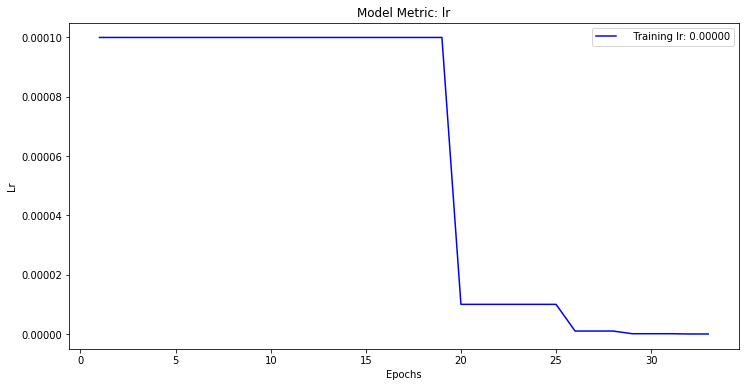

In [ ]:
plot_keras_history(history_gru)

In [ ]:
# from tensorflow.python.keras.models import load_model

# model2.save('model_cnn.h5')  # creates a HDF5 file 'my_model.h5'

# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

In [ ]:
# model_gru.save_weights('model_gru_weights.h5')

# LSTM-Model

In [47]:
#model hyperparams

nb_classes = len(y_train_enc[0])
print('Number of Classes (Personality Components): {}'.format(nb_classes))
nb_epoch = 50
batch_size = 128
dropout_rate = 0.5

Number of Classes (Personality Components): 4


## Model Callbacks

In [46]:
monitor = 'val_loss'

model_lstm = 'model_lstm.h5'

callbacks_lstm = [
    # Stop training when a monitored quantity has stopped improving.
    EarlyStopping(monitor=monitor,
                  patience=5,
                  verbose=1,
                  restore_best_weights=True),
    
    # Save the model after every epoch of the monitor quantity improves
    ModelCheckpoint(filepath=model_lstm,
                    monitor=monitor,
                    save_best_only=True,
                    save_weights_only=False,
                    verbose=1),
    
    # Reduce learning rate when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor,
                      factor=0.1,
                      patience=3,
                      verbose=1,
                      restore_best_weights=True)

]

## Model Architecture

In [54]:
# model_lstm = Sequential()
# model_lstm.add(Embedding(max_words, embedding_dim, input_length=maxlen, weights=[embedding_matrix],trainable=False))
# model_lstm.add(Bidirectional(LSTM(64)))
# model_lstm.add(Dropout(0.5))
# model_lstm.add(Dense(16, activation='tanh'))
# model_lstm.add(Dropout(0.5))
#  Adding a dense output laye
# model_lstm.add(Dense(nb_classes, activation='sigmoid'))
# model_lstm.build(X_train_enc.shape) 
# model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model_lstm.summary()


print('Building model...')
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embedding_dim, input_length=maxlen, weights=[embedding_matrix],trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(8, activation=mish),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(nb_classes, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy','accuracy'])
model_lstm.summary()

Building model...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 280, 300)          9000000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              186880    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 1032      
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 4)                 36        
                                    

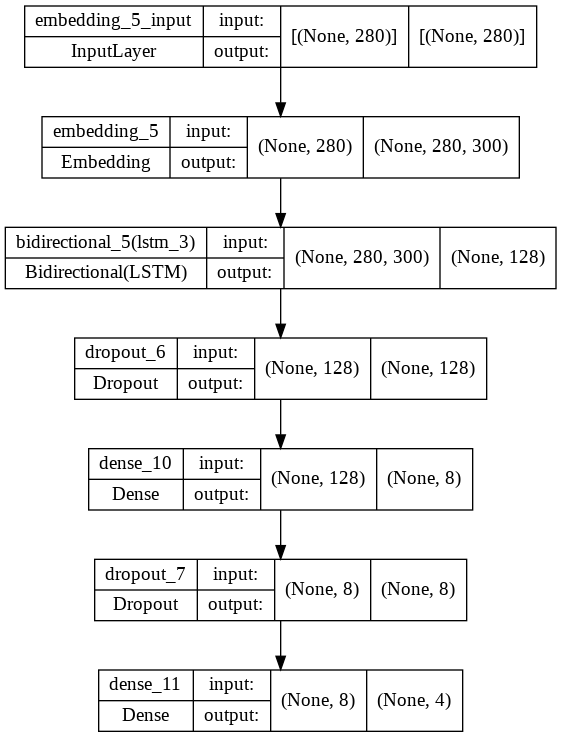

In [63]:
plot_model(model_lstm, show_shapes=True)

In [55]:
# Fit data to model
history_lstm=model_lstm.fit(X_train_enc, y_train_enc,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=2,
    validation_data=(X_val_enc,y_val_enc),
    callbacks=callbacks_lstm
)


Epoch 1/100

Epoch 00001: val_loss did not improve from 0.54345
55/55 - 5s - loss: 0.6515 - binary_accuracy: 0.6524 - accuracy: 0.2879 - val_loss: 0.6072 - val_binary_accuracy: 0.6917 - val_accuracy: 0.2753 - lr: 0.0010 - 5s/epoch - 98ms/step
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.54345
55/55 - 2s - loss: 0.6265 - binary_accuracy: 0.6712 - accuracy: 0.2919 - val_loss: 0.5933 - val_binary_accuracy: 0.7023 - val_accuracy: 0.2804 - lr: 0.0010 - 2s/epoch - 30ms/step
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.54345
55/55 - 2s - loss: 0.6138 - binary_accuracy: 0.6739 - accuracy: 0.2817 - val_loss: 0.5859 - val_binary_accuracy: 0.7017 - val_accuracy: 0.2753 - lr: 0.0010 - 2s/epoch - 30ms/step
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.54345
55/55 - 2s - loss: 0.6028 - binary_accuracy: 0.6796 - accuracy: 0.2868 - val_loss: 0.5781 - val_binary_accuracy: 0.7039 - val_accuracy: 0.2766 - lr: 0.0010 - 2s/epoch - 30ms/step
Epoch 5/100

Epoch 00005: va

## Model Evaluation

In [56]:
# #evaluate and store on score variable the test dataset
score_lstm = model_lstm.evaluate(
    X_val_enc,    
    y_val_enc,             
    batch_size=batch_size,   
    verbose=2)


7/7 - 0s - loss: 0.5441 - binary_accuracy: 0.7426 - accuracy: 0.3457 - 163ms/epoch - 23ms/step


In [57]:
print('\nValidation binary_crossentropy: {}'.format(score_lstm[0]))
print('\nValidation binary accuracy: {:.3f} %'.format(score_lstm[1]*100))
print('\nValidation accuracy: {:.3f} %'.format(score_lstm[2]*100))


Validation binary_crossentropy: 0.544115424156189

Validation binary accuracy: 74.264 %

Validation accuracy: 34.571 %


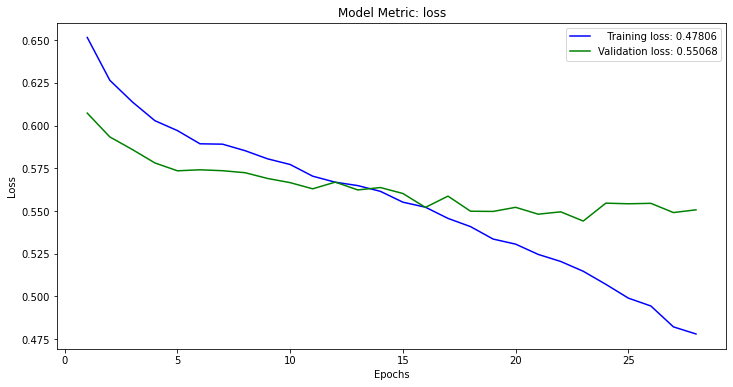

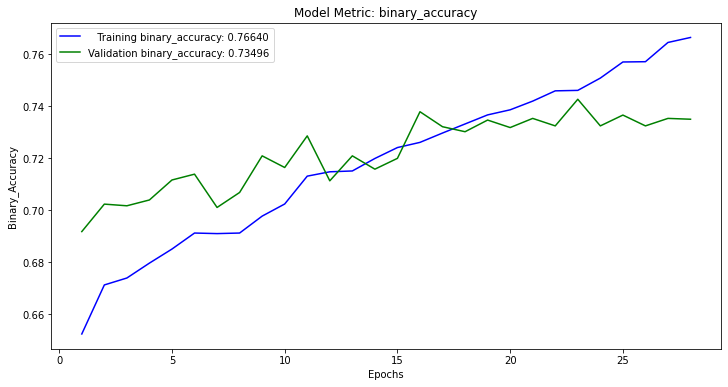

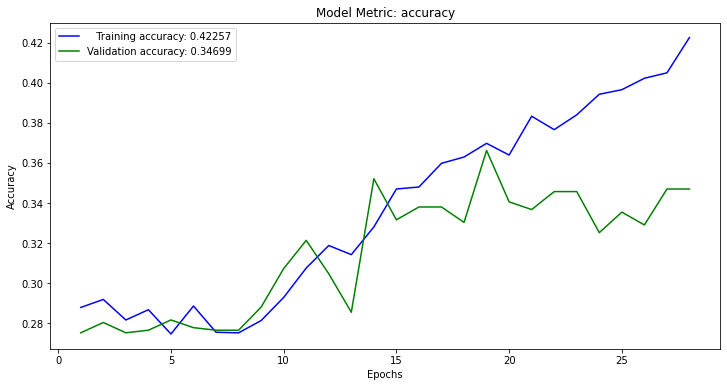

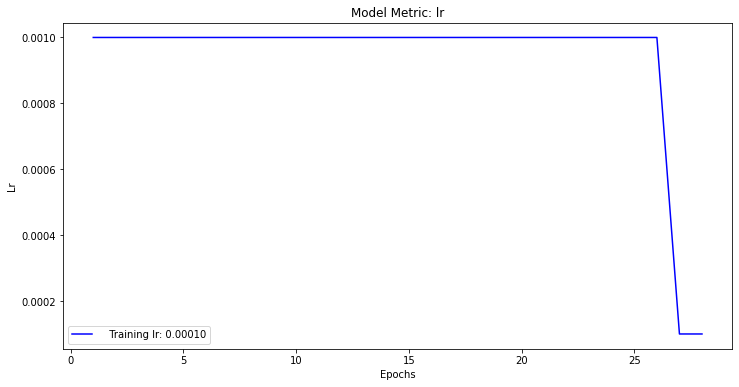

In [64]:
plot_keras_history(history_lstm)

In [ ]:
# model_lstm.save_weights('model_lstm_weights.h5')

## Conclusion 

As we can observe, we implemented two RNN models in the current notebook, one Bidirectional GRU and one Bidirectional LSTM. These models did not perform as well as expected although they are highly recommended in text classification problems.

***GRU:***

Validation binary crossentropy: 0.547

Validation binary accuracy: 73.62 %

Validation accuracy: 35.21 %

***LSTM:***

Validation binary crossentropy: 0.544

Validation binary accuracy: 74.26 %

Validation accuracy: 34.57 %